### PCA 

In [225]:
import numpy as np
import pandas as pd
from reco_systems.filter import filter_df
from reco_systems.user_game_matrix import *
from reco_systems.CF_knn import *
from reco_systems.evaluation import *
from copy import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [226]:
# import DB et set min_reviews

folder = "database_cleaned"
avis_clean  = pd.read_csv(f"{folder}/avis_clean.csv", index_col=0)
jeux_clean  = pd.read_csv(f"{folder}/jeux_clean.csv", index_col=0)
users       = pd.read_csv(f"{folder}/users.csv", index_col=0)

min_reviews = 20 # change to set one

In [227]:
# filter data with the minimum reviews
filtered_avis = filter_df(avis_clean, min_reviews)

# create user-game matrix
user_game_ratings, mask_ratings, users_table_assoc, games_table_assoc = get_matrix_user_game(filtered_avis)

11201 10549
1259 1267
904 1158
873 1140
869 1136
868 1135


In [228]:
# not centered version 
user_game_ratings.shape

(868, 1135)

In [229]:
# calculate the covariance matrix on the centered data
# take eigenvectors and values of this cov matrix

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# scale the data
scaled_df = StandardScaler().fit_transform(user_game_ratings.todense()) # scale our matrix, values - mean / std

In [230]:
# reducing the number of components
pca = PCA(n_components=2) 
components = pca.fit_transform(scaled_df)

In [231]:
pca.explained_variance_ratio_ # very low for this

array([0.05849994, 0.03310563])

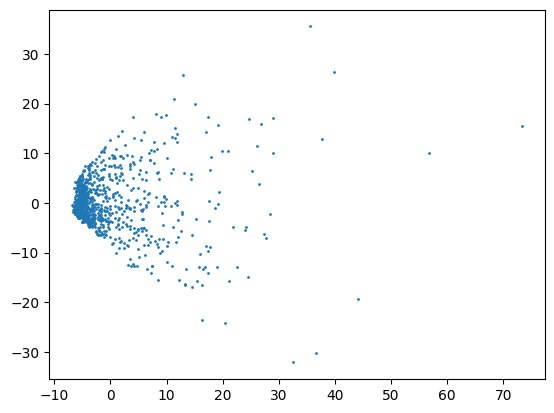

In [232]:
plt.scatter(components[:, 0], components[:, 1], s=1)

In [233]:
# test with another matrix
# take matrix user and game caracteristic

In [234]:
# first choose the most popular game categories NO CAPITALIZE
categories = jeux_clean["Type"].str.split(r'[|/]').dropna()
lst_categories = np.unique([item.strip() for list_items in categories for item in list_items])
lst_categories, len(lst_categories)

(array(['Abstrait', 'Adresse', 'Affrontement', 'Afrique', 'Alignement',
        'Amateur', 'Ambiance', 'Animaux', 'Antiquité', 'Archive', 'Art',
        'Asie', 'Astronomie et Espace', 'Autres', 'Avant-vente',
        'Aventures dans la jungle', 'Aviation', 'Bande dessinée',
        'Blocage', 'Bluff', 'Bourse & finances', 'Cambriolage', 'Capture',
        'Card-driven', 'Cartes à jouer', 'Casse-tête', 'Casual',
        'Catastrophe', 'Chant & Danse', 'Chat', 'Chiffres', 'Chifoumi',
        'Choix simultanés', 'Cirque', 'Cochon', 'Collection',
        'Colonisation', 'Combinaison', 'Commerce', 'Connaissances',
        'Connexions', 'Conquête', 'Construction',
        'Contes, Mythes & Légendes', 'Coopération', 'Course', 'Créativité',
        'Cuisine', 'Cyberpunk', 'Cyclisme', 'Deck building', 'Desert',
        'Dessin', 'Devinette', 'Dextérité', 'Diplomatie', 'Divers',
        'Draft', 'Duplicate', 'Déduction', 'Défausse', 'Déplacement',
        'Dés', 'Echange - troc', 'Ecologie', 'E

In [235]:
# for each categories the number of games
count_cat = np.array([[category, int(jeux_clean['Type'].str.contains(category, na=False, regex=False).sum())] for category in lst_categories])
# two best categories
sorted_categ = count_cat[count_cat[:,1].astype(int).argsort()[::-1]]
sorted_categ

array([['Jeux de plateau', '3163'],
       ['Jeux de cartes', '1742'],
       ['Jeux de guerre', '444'],
       ['Affrontement', '427'],
       ['Autres', '397'],
       ['Placement', '396'],
       ['Gestion', '395'],
       ['Médiéval', '379'],
       ['Hasard (Dé, Cartes, ...)', '363'],
       ['Jeux de figurines', '301'],
       ['Casse-tête', '297'],
       ['Combinaison', '263'],
       ['Déplacement', '257'],
       ['Ambiance', '250'],
       ['Jeux de pions', '244'],
       ['Médiéval-fantastique', '239'],
       ['Dés', '232'],
       ['Guerre', '226'],
       ['Coopération', '210'],
       ['Gestion de main', '204'],
       ['Animaux', '185'],
       ['Exploration', '185'],
       ['Jeu de carte à collectionner', '184'],
       ['Jeux de connaissances', '180'],
       ['Bluff', '179'],
       ['Fantastique', '172'],
       ['Majorité', '161'],
       ['Jeux de dés', '160'],
       ['Jeu de logique', '157'],
       ['Science fiction', '153'],
       ['Prise de risque', '153']

In [236]:
#  for each cat, the game ids for sorted df
jeux_nonan = jeux_clean.dropna()
jeux_nonan = jeux_nonan[jeux_nonan["Game id"].isin(filtered_avis["Game id"].unique())]
cat_games = [[cat, list(jeux_nonan.loc[jeux_nonan['Type'].str.lower().str.contains(cat.lower(), na=False, regex=False)]["Game id"])] for cat in lst_categories]
ar_cat_games = np.array(cat_games, dtype=object)[:,1]

In [237]:
# associated index game
game_ids = pd.Series(np.unique(np.concatenate(ar_cat_games)).astype(int)) # game ids concerned for matrix
# associated index users 
users_id = pd.Series(np.unique(filtered_avis["User id"]))

In [238]:
game_ids.shape, users_id.shape

((842,), (868,))

In [239]:
# using pivot table -> separate | into many rows, after counting the categories
# merge the databases
avis_jeux = jeux_nonan[["Game id", "Type"]].merge(filtered_avis[["User id", "Game id", "Rating"]], on='Game id')

# for each category create a new row
types = avis_jeux['Type'].str.split(r'[|/]').explode()
user_game_type = pd.DataFrame({
    'User id': avis_jeux['User id'].repeat(avis_jeux['Type'].str.split(r'[|/]').apply(len)),
    'Game id': avis_jeux['Game id'].repeat(avis_jeux['Type'].str.split(r'[|/]').apply(len)),
    'Type': types
}).drop_duplicates()


In [240]:
user_type = user_game_type[["User id", "Type"]].drop_duplicates().pivot_table(index ="User id", columns="Type", aggfunc='size', fill_value=0)
user_type

Type,famille,mots,Abstrait,Adresse,Affrontement,Afrique,Alignement,Amateur,Ambiance,Animaux,...,Taquin,Toucher,Trahison,Transport de marchandise,Tuile,Ville,Volcan,Vote,Zombies,équipe
User id,,,,,,,,,,,,,,,,,,,,,
0,1,0,0,0,1,0,0,0,0,1,...,0,0,1,1,0,1,0,0,1,0
1,1,1,1,1,1,0,1,0,1,1,...,1,1,1,1,1,1,1,1,1,1
2,1,1,1,1,1,0,0,0,1,1,...,1,0,1,1,1,1,1,0,0,0
3,1,1,0,1,1,0,1,0,1,1,...,1,0,1,1,1,1,1,0,1,1
6,1,0,1,1,0,0,0,0,0,1,...,0,0,1,0,1,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6783,1,0,0,0,0,1,0,0,1,1,...,0,0,0,1,0,1,0,0,0,0
6818,0,0,0,1,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
6961,0,0,0,1,1,0,0,0,1,1,...,1,0,1,0,0,0,0,0,1,0


In [241]:
game_type = user_game_type[["Game id", "Type"]].drop_duplicates().pivot_table(index ="Game id", columns="Type", aggfunc='size', fill_value=0)
game_type

Type,famille,mots,Abstrait,Adresse,Affrontement,Afrique,Alignement,Amateur,Ambiance,Animaux,...,Taquin,Toucher,Trahison,Transport de marchandise,Tuile,Ville,Volcan,Vote,Zombies,équipe
Game id,,,,,,,,,,,,,,,,,,,,,
15,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
62,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
82,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
120,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
145,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10474,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
10497,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
10508,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


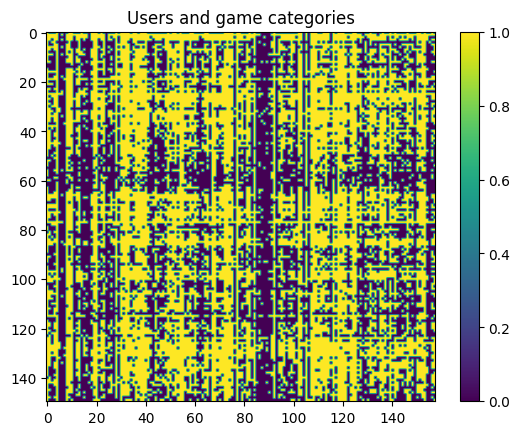

In [242]:
plt.imshow(user_type.head(150))
plt.title("Users and game categories")
plt.colorbar()

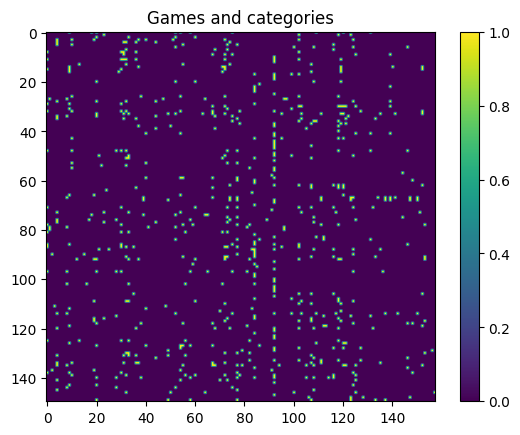

In [243]:
plt.imshow(game_type.head(150))
plt.title("Games and categories")
plt.colorbar()

## Clusters

### Users

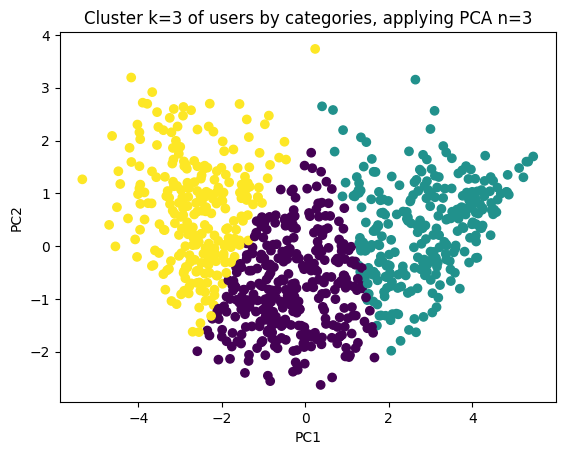

In [247]:
# apply PCA to see the clusters
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
user_type_2d = pca.fit_transform(user_type)

# clustering the users
# Perform K-Means clustering
kmeans = KMeans(n_clusters=3)  
clustered = kmeans.fit_predict(user_type_2d)

# plot
plt.scatter(user_type_2d[:,0], user_type_2d[:,1], c=clustered)
plt.title("Cluster k=3 of users by categories, applying PCA n=3")
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

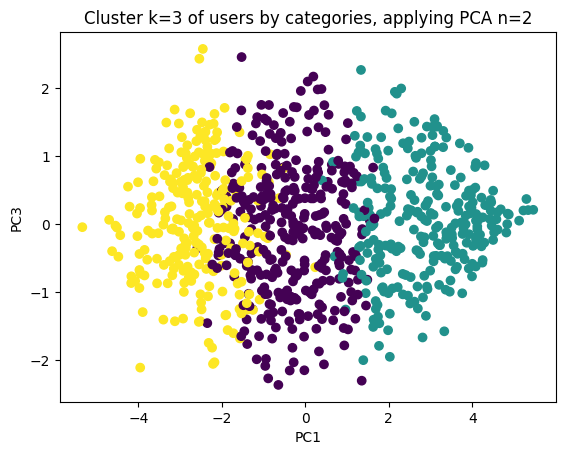

In [248]:
# plot
plt.scatter(user_type_2d[:,0], user_type_2d[:,2], c=clustered)
plt.title("Cluster k=3 of users by categories, applying PCA n=2")
plt.xlabel('PC1')
plt.ylabel('PC3')
plt.show()

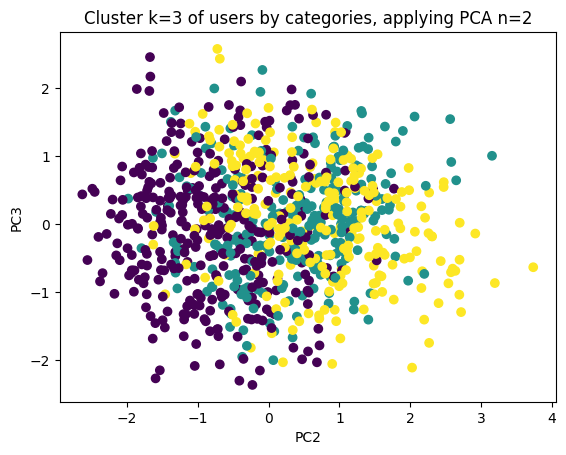

In [249]:
# plot
plt.scatter(user_type_2d[:,1], user_type_2d[:,2], c=clustered)
plt.title("Cluster k=3 of users by categories, applying PCA n=2")
plt.xlabel('PC2')
plt.ylabel('PC3')
plt.show()

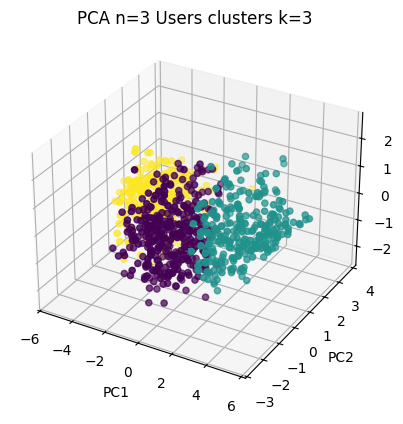

In [250]:
# # visualisation in 3D
# pca = PCA(n_components=3)
# user_type_2d = pca.fit_transform(user_type)

# kmeans = KMeans(n_clusters=3)  
# clustered = kmeans.fit_predict(user_type_2d)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(user_type_2d[:,0], user_type_2d[:,1], user_type_2d[:,2], c=clustered)

ax.set_title("PCA n=3 Users clusters k=3")
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

plt.show()

### Games

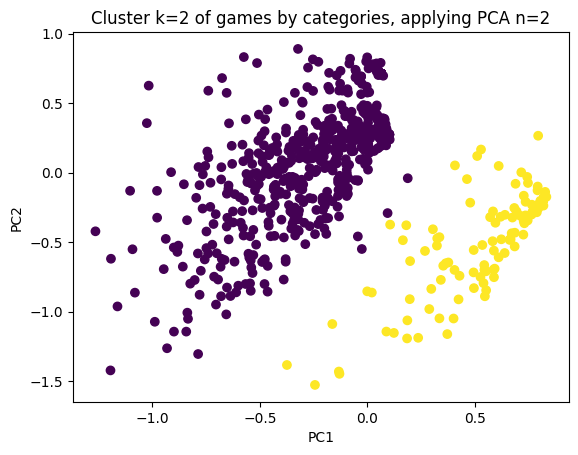

In [251]:
# apply PCA to see the clusters
pca = PCA(n_components=2)
game_type_2d = pca.fit_transform(game_type)

# clustering the games
# Perform K-Means clustering
kmeans = KMeans(n_clusters=2)  
clustered = kmeans.fit_predict(game_type_2d)

# plot
plt.scatter(game_type_2d[:,0], game_type_2d[:,1], c=clustered)
plt.title("Cluster k=2 of games by categories, applying PCA n=2")
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

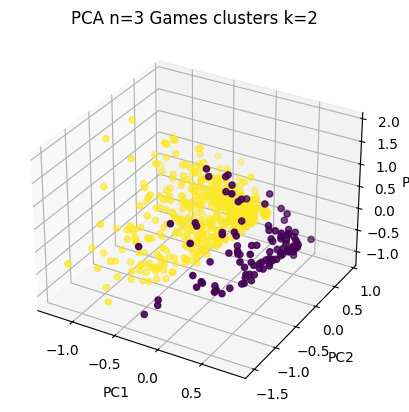

In [252]:
# visualisation in 3D
pca = PCA(n_components=3)
game_type_2d = pca.fit_transform(game_type)

kmeans = KMeans(n_clusters=2)  
clustered = kmeans.fit_predict(game_type_2d)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(game_type_2d[:,0], game_type_2d[:,1], game_type_2d[:,2], c=clustered)
ax.set_title("PCA n=3 Games clusters k=2")
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

plt.show()

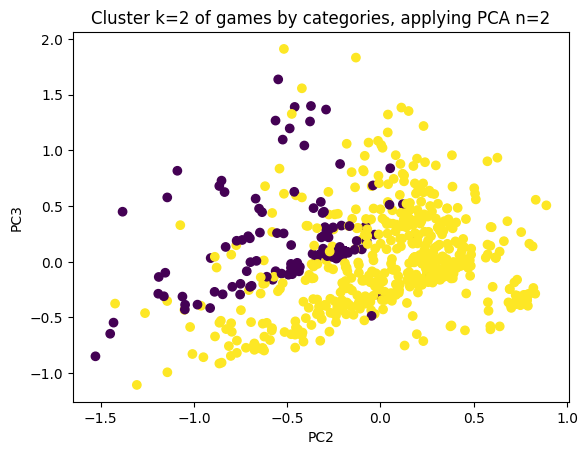

In [253]:
# PCA 3 visualisez in different parts
# plot
plt.scatter(game_type_2d[:,1], game_type_2d[:,2], c=clustered)
plt.title("Cluster k=2 of games by categories, applying PCA n=2")
plt.xlabel("PC2")
plt.ylabel("PC3")
plt.show()

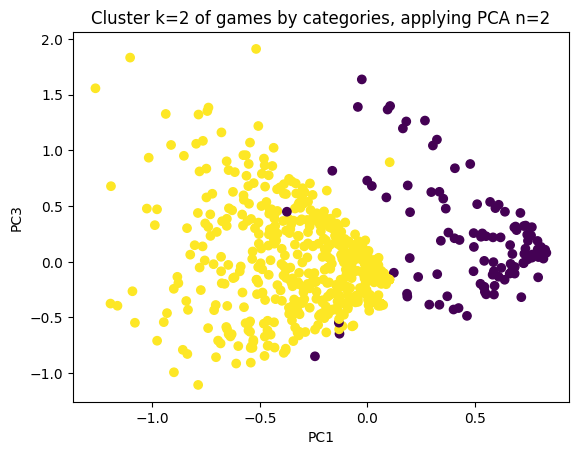

In [254]:
# PCA 3 visualisez in different parts
# plot
plt.scatter(game_type_2d[:,0], game_type_2d[:,2], c=clustered)
plt.title("Cluster k=2 of games by categories, applying PCA n=2")
plt.xlabel("PC1")
plt.ylabel("PC3")
plt.show()

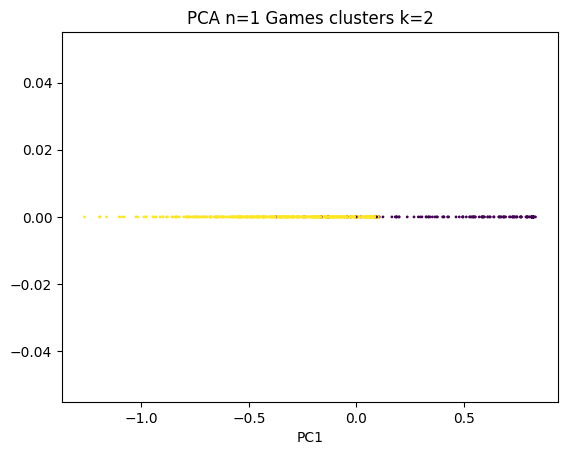

In [255]:
# visualisation in 3D
pca = PCA(n_components=1)
game_type_2d = pca.fit_transform(game_type)

fig = plt.figure()
plt.scatter(game_type_2d, np.zeros(len(game_type_2d)),c=clustered, s=1)
plt.title("PCA n=1 Games clusters k=2")
plt.xlabel('PC1')

plt.show()

In [256]:
class0 = np.where(clustered == 0)[0]
class1 = np.where(clustered == 1)[0]
class0_label = game_type.iloc[class0].sum().sort_values(ascending=False).index[0]
class1_label =game_type.iloc[class1].sum().sort_values(ascending=False).index[0]
game_type.iloc[class0].sum().sort_values(ascending=False), game_type.iloc[class1].sum().sort_values(ascending=False)

(Type
 Jeux de plateau             220
 Placement                    22
 Déplacement                  20
 Majorité                     20
 Hasard (Dé, Cartes, ...)     18
                            ... 
 Cochon                        0
 Chiffres                      0
 Catastrophe                   0
 Polaire                       0
 équipe                        0
 Length: 158, dtype: int64,
 Type
 Jeux de cartes                       117
 Hasard (Dé, Cartes, ...)              87
 Combinaison                           83
 Placement                             76
 Affrontement                          76
                                     ... 
 Mime                                   1
 Astronomie et Espace                   1
 Jeux de figurines à collectionner      1
 Archive                                0
 Jeux de rôles                          0
 Length: 158, dtype: int64)

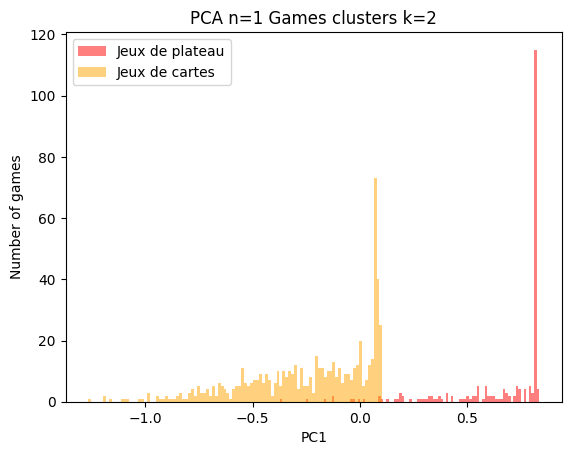

In [257]:
# visualisation in 3D
pca = PCA(n_components=1)
game_type_2d = pca.fit_transform(game_type)

fig = plt.figure()
plt.hist(game_type_2d[np.where(clustered == 0)[0]], bins=100, color="red", alpha=0.5, label=class0_label)
plt.hist(game_type_2d[np.where(clustered == 1)[0]], bins=100, color="orange", alpha=0.5, label=class1_label)
plt.title("PCA n=1 Games clusters k=2")
plt.xlabel('PC1')
plt.ylabel("Number of games")
plt.legend()
plt.show()

### Clustering the users on the two most popular categories

In [258]:
user_type_2cat = user_type[["Jeux de cartes", "Jeux de plateau"]]
cat_size = user_type_2cat.groupby(["Jeux de cartes", "Jeux de plateau"]).value_counts().reset_index()
cat_size

,Jeux de cartes,Jeux de plateau,count
0,0,0,14
1,0,1,59
2,1,0,22
3,1,1,773


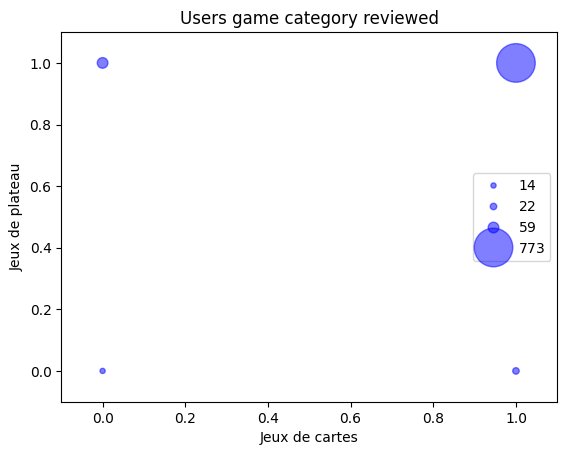

In [259]:
#representing users
plot = plt.scatter(cat_size["Jeux de cartes"],cat_size["Jeux de plateau"], s=cat_size["count"],c="blue", alpha = 0.5)
plt.ylim(-0.1, 1.1)
plt.xlim(-0.1, 1.1)
plt.title("Users game category reviewed")
plt.xlabel("Jeux de cartes")
plt.ylabel("Jeux de plateau")
plt.legend(*plot.legend_elements("sizes", alpha=0.5, c="blue"))
plt.show()

In [260]:
# on the 3 best categorie
user_3cat = user_type[["Jeux de cartes", "Jeux de plateau", "Jeux de guerre"]]
user_3cat

Type,Jeux de cartes,Jeux de plateau,Jeux de guerre
User id,,,
0,1,1,0
1,1,1,0
2,1,1,0
3,1,1,0
6,1,1,0
...,...,...,...
6783,1,1,0
6818,0,0,0
6961,1,1,0


In [263]:
cat_size = user_3cat.groupby(["Jeux de cartes", "Jeux de plateau", "Jeux de guerre"]).value_counts().reset_index()
cat_size

,Jeux de cartes,Jeux de plateau,Jeux de guerre,count
0,0,0,0,14
1,0,1,0,53
2,0,1,1,6
3,1,0,0,21
4,1,0,1,1
5,1,1,0,716
6,1,1,1,57


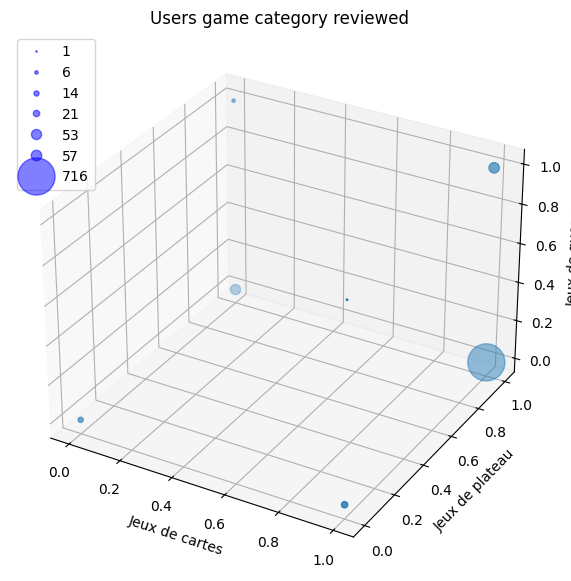

In [301]:
# visualisation in 3D
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(projection='3d')
plot = ax.scatter(cat_size["Jeux de cartes"], cat_size["Jeux de plateau"], cat_size["Jeux de guerre"], s=cat_size["count"])
plt.legend(*plot.legend_elements("sizes", alpha=0.5, c="blue"))
ax.set_title("Users game category reviewed")
ax.set_xlabel('Jeux de cartes')
ax.set_ylabel('Jeux de plateau')
ax.set_zlabel('Jeux de guerre')
plt.show()


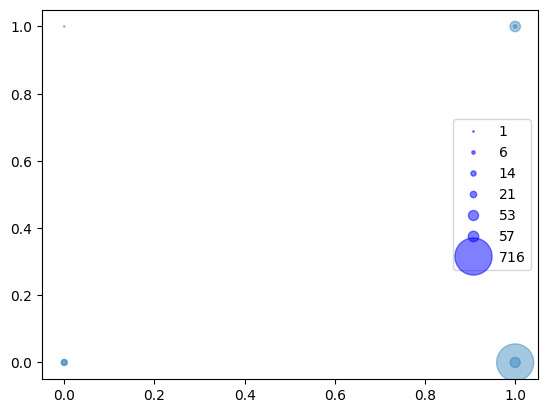

In [289]:
# visualisation in 2d using PCA

plot = plt.scatter(cat_size["Jeux de plateau"], cat_size["Jeux de guerre"], s=cat_size["count"], alpha=0.4)
plt.legend(*plot.legend_elements("sizes", alpha=0.5, c="blue"))
plt.show()

In [212]:
# verify the matrix is working okay
# tmp2[tmp2["User id"] == 0]['Type'].unique().shape
# np.unique([el for sub in avis_jeux[avis_jeux["User id"] == 0]["Type"].str.split(r'[|/]').tolist() for el in sub]).shape
# user_type.loc[0].sum()
# len(user_game_type[user_game_type["User id"] == 1]["Type"].unique())